In [1]:
from fm4ar.models.build_model import build_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch.cuda.amp import autocast

In [52]:
# load model
experiment_dir = Path('./experiments/12_11_2/')
file_path = Path(f'./{experiment_dir}/model__best.pt')
model = build_model(experiment_dir,file_path=file_path, device = 'cuda:0')

In [39]:
# load data
dataset_dir = './dataset/FM_dataset.pkl'
data = pd.read_pickle(dataset_dir)
data.head()

,zenith,azimuth,event_no,energy,latent_vec
0,2.287569,4.252627,23.0,944.297598,"[0.0, 0.0, 0.0, 0.0, 122.22716, 0.0, 0.0, 0.0,..."
1,2.081253,4.374673,27.0,1678.264241,"[0.0, 0.0, 0.0, 0.0, 62.239994, 0.0, 0.0, 0.0,..."
2,2.738480,2.118246,31.0,24595.207684,"[0.0, 114.393036, 0.0, 0.0, 328.88135, 0.0, 0...."
3,2.252435,2.653680,36.0,124.191728,"[0.0, 10.383446, 0.0, 0.0, 62.476994, 0.0, 0.0..."
4,2.033719,1.189017,52.0,231.562639,"[0.0, 0.0, 0.0, 0.0, 18.572924, 0.0, 0.0, 18.2..."


In [ ]:
# prepare grid for evaluation
delta = 0.5
ticks = 1
event_id = 6
true_zenith, true_azimuth = data['zenith'][event_id], data['azimuth'][event_id]
zenith = np.linspace(true_zenith-delta, true_zenith+delta, ticks)
azimuth = np.linspace(true_azimuth-delta, true_azimuth+delta, ticks)
zenith = np.linspace(0, np.pi, ticks)
azimuth = np.linspace(0, 2*np.pi, ticks)
zenith, azimuth = np.meshgrid(zenith, azimuth)

# # spherical
# thetas = torch.tensor([zenith.flatten(), azimuth.flatten()]).T.to(model.device).float()

# cartesian
x = np.sin(zenith) * np.cos(azimuth)
y = np.sin(zenith) * np.sin(azimuth)
z = np.cos(zenith)
thetas = torch.tensor([x.flatten(), y.flatten(), z.flatten()]).T.to(model.device).float()


fluxes = torch.tensor(data['latent_vec'][event_id]).repeat(thetas.shape[0],1).to(model.device).float()
context = {'flux': fluxes}
print(thetas.shape,fluxes.shape)

torch.Size([2500, 3]) torch.Size([2500, 128])


In [ ]:
# evaluate model
with torch.no_grad():
    log_prob = model.log_prob_batch(thetas,context, 
                                    tolerance=1.0e-4).to('cpu')


In [55]:
torch.cuda.empty_cache()

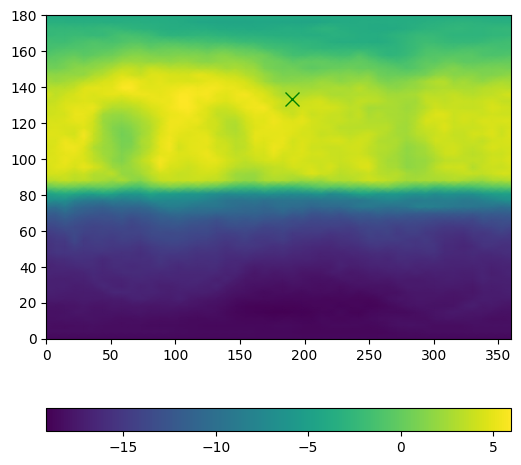

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.pcolormesh(
    np.degrees(azimuth),
    np.degrees(zenith),
    log_prob.detach().cpu().numpy().reshape(ticks, ticks),
    cmap="viridis",
    shading="gouraud",
)
cb = plt.colorbar(cax, ax=ax, orientation="horizontal")
ax.plot(
    np.degrees(true_azimuth),
    np.degrees(true_zenith),
    "gx",
    markersize=10,
    label="truth",
)


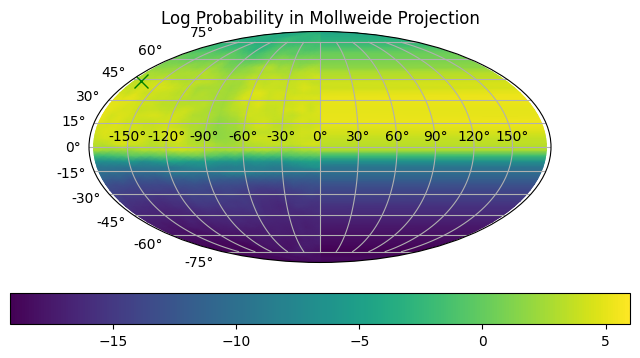

In [57]:
from matplotlib.projections import get_projection_class

# Set up the Mollweide projection
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": "mollweide"})

# Adjust azimuth to fit Mollweide's range (-π to π)
azimuth = (azimuth + np.pi) % (2 * np.pi) - np.pi

# Create the pcolormesh in Mollweide projection
cax = ax.pcolormesh(
    azimuth,
    -(np.pi / 2 - zenith),  # Mollweide uses latitude, which is π/2 - zenith
    log_prob.detach().cpu().numpy().reshape(ticks, ticks),
    cmap="viridis",
    shading="gouraud",
)

# Add colorbar
cb = plt.colorbar(cax, ax=ax, orientation="horizontal", pad=0.1)

# Plot the truth point
true_azimuth_rad = (true_azimuth + np.pi) % (2 * np.pi) - np.pi
true_zenith_rad = -(np.pi / 2 - true_zenith)
ax.plot(
    true_azimuth_rad,
    true_zenith_rad,
    "gx",
    markersize=10,
    label="truth",
)

# Add labels and grid for clarity
ax.grid(True)
ax.set_title("Log Probability in Mollweide Projection")

plt.show()
